# **Projet BIG DATA CCF**
 Réalisé par :

 **Mehdi EL AYADI**

 **Romain DIOP**

## **Introduction**
Ce code est une implémentation de deux approches différentes de l'algorithme CFF (Connected Components Framework), appliqué sur le jeu de données du graphique web de Google et sur des données générés aléatoirement pour tester les performances.

In [ ]:
!pip install pyspark
from pyspark import SparkConf
from pyspark.context import SparkContext
sc = SparkContext(appName="Project")
import time 
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

### **A - CCF-iterate**
1. Chargement du jeu de données dans un RDD
2. Nettoyage des données en filtrant toutes les lignes avec le caractère "#" pour retirer l'en-tête de notre fichier et en divisant les données en paires (clé, valeur)
3. Inversion du RDD d'origine pour créer un RDD inversé
4. Combinaison du RDD d'origine et du RDD inversé grâce à la fonction union de spark
5. Regroupement du RDD graphique par clé et obtention des valeurs sous forme de liste 
6. Partitionnement du RDD graphique en 500 partitions pour une meilleure parallélisation et mise en cache du RDD résultant pour un accès plus rapide
7. Conversion des clés et des valeurs de chaînes de caractères en entiers
8. Extraction de la valeur minimale dans chaque liste et filtrage des paires dont la clé est inférieure ou égale à la valeur minimale
9. Suppression de la valeur minimale de chaque liste du RDD

10. Comptage du nombre de nouvelles paires 

        CCF-Iterate
        map(key, value)
        emit(key, value)
        emit(value, key)
        reduce(key, < iterable > values)
        min ← key
        for each (value ∈ values)
        if(value < min)
        min ← value
        valueList.add(value)
        if(min < key)
        emit(key, min)
        for each (value ∈ valueList)
        if(min 6= value)
        Counter.NewPair.increment(1)
        emit(value, min)


### **B - CCF-dedup**
1. La première ligne de code crée un nouvel RDD  en extrayant le nœud source de chaque arête de google_graph et le poids de celle ci et renvoie une paire clé-valeur de la forme (nœud source, poids)

2. La deuxième ligne de code crée un deuxième RDD en en faisant correspondre le nœud cible de chaque arête à son poids en itérant sur la liste de nœud cible et renvoie une paire clé-valeur de la forme (nœud cible, poids).

3. La troisième ligne de code fusionne les deux RDD précédents en un seul RDD en utilisant l'opération d'union. Ainsi, l'ensemble final de paires clé-valeur contiendra toutes les paires générées par les deux premières lignes de code

        CCF-Dedup
        map(key, value)
        temp.entity1 ← key
        temp.entity2 ← value
        emit(temp, null)
        reduce(key, < iterable > values)
        emit(key.entity1, key.entity2)





In [3]:
#google_graph = sc.textFile("drive/MyDrive/BIGDATA/web-Google.txt")
google_graph = sc.textFile("drive/MyDrive/miage_if/web-Google.txt")

# Nettoyage des données au préalable
google_graph = google_graph.filter(lambda x: "#" not in x).map(lambda x: x.split("\t")).map(lambda x: (x[0], x[1]))   


In [4]:
def CCF_classic(graph):
    i = 0
    nombre_paires = 1
    while nombre_paires > 0:
      #print(f"iteration {i}")
      #CCF-iterate
      graph_inv = graph.map(lambda x: (x[1], x[0]))
      graph = graph.union(graph_inv)
      graph = graph.groupByKey().mapValues(list).partitionBy(100).cache()
      graph = graph.map(lambda x: (int(x[0]), list(map(int, x[1])))).map(lambda x: (x[0], x[1], min(x[1]))).filter(lambda x: x[0] > x[2]).map(lambda x: (x[0], [val for val in x[1] if val != x[2]], x[2]))
      nombre_paires = graph.map(lambda x: len(x[1])).sum()


      #CCF-dedup
      emit_1 = graph.map(lambda x: (x[0], x[2]))
      emit_2 = graph.flatMap(lambda x: [(val, x[2]) for val in x[1]])
      emit_tot = emit_1.union(emit_2)
      # creation du nouvel RDD graph2
      graph = emit_tot.map(lambda x: ((x[0], x[1]), [])).groupByKey().mapValues(list).map(lambda x: (x[0][0], x[0][1]))
      #print(f"Nombre de paires : {nombre_paires}")
      i += 1
    return graph

1. Démarrage d'un chronomètre pour mesurer le temps d'exécution
2. Traitement des données en utilisant la fonction CFF_iterate (renommée "process" dans le code)
3. Comptage du nombre de composantes connectées en prenant les valeurs distinctes de la deuxième élément de chaque paire et en les comptant
4. Recherche de la plus grande composante connectée en regroupant le RDD de sortie par le deuxième élément de chaque paire et en trouvant la longueur maximale des groupes résultants
5. Calcul du temps écoulé en soustrayant l'heure de début de l'heure actuelle

In [ ]:
start_time = time.time()
output = CCF_classic(google_graph)

n_components = output.map(lambda x : x[1]).distinct().count()
print(f"\n # components : {n_components}")

largest_component = output.groupBy(lambda x : x[1]).map(lambda x : len(x[1])).max() + 1
print(f"\n The largest component has {largest_component} elements")

time_ccf = time.time() - start_time
print("\n Total elasped time :", time_ccf, " s")

iteration 0
Nombre de paires : 8552232
iteration 1
Nombre de paires : 4758451
iteration 2
Nombre de paires : 3278772
iteration 3
Nombre de paires : 3888454
iteration 4
Nombre de paires : 1905323
iteration 5
Nombre de paires : 86783
iteration 6
Nombre de paires : 1318
iteration 7
Nombre de paires : 0

 # components : 2746

 The largest component has 855802 elements

 Total elasped time : 1174.3634881973267  s


# **CCF-Iterate avec 2ème tri**
La principale différence entre les deux fonctions est que la seconde (process_CCF_sorted) trie la liste des voisins de chaque sommet avant le traitement, tandis que la première (process) ne le fait pas.
pseudo code : 
    CCF-Iterate (w. secondary sorting)

      map(key, value)

      emit(key, value)

      emit(value, key)

      reduce(key, < iterable > values)

      minV alue ← values.next()

      if(minV alue < key)

          emit(key, minV alue)

          for each (value ∈ values)

              Counter.NewPair.increment(1)

          emit(value, minV alue)



In [5]:
def CCF_sorted(graph_for_sorted):
    i = 0
    nombre_paires = 1
    while nombre_paires > 0:
        #print(f"iteration {i}")
        
        # CCF-iterate
        graph_for_sorted_inv = graph_for_sorted.map(lambda x: (x[1], x[0]))
        graph_for_sorted = graph_for_sorted.union(graph_for_sorted_inv)
        graph_for_sorted = graph_for_sorted.groupByKey().mapValues(list).partitionBy(100).cache()
        graph_for_sorted = graph_for_sorted.map(lambda x: (int(x[0]), sorted(list(map(int, x[1])))))
        graph_for_sorted = graph_for_sorted.filter(lambda x: x[1][0] < x[0]).map(lambda x: (x[0], x[1][1:], x[1][0]))
        nombre_paires = graph_for_sorted.map(lambda x: len(x[1])).sum()

        # CCF-dedup
        emit_1 = graph_for_sorted.map(lambda x: (x[0], x[2]))
        emit_2 = graph_for_sorted.flatMap(lambda x: [(val, x[2]) for val in x[1]])
        emit_tot = emit_1.union(emit_2)
        
        # creation du nouvel RDD graph_for_sorted2
        graph_for_sorted = emit_tot.map(lambda x: ((x[0], x[1]), [])).groupByKey().mapValues(list).map(lambda x: (x[0][0], x[0][1]))
        
        #print(f"Nombre de paires : {nombre_paires}")
        i += 1
    return graph_for_sorted

In [ ]:
start_time = time.time()
output = CCF_sorted(google_graph)

n_components = output.map(lambda x: x[1]).distinct().count()
print(f"\n# de composants : {n_components}")

largest_component = output.groupBy(lambda x: x[1]).map(lambda x: len(x[1])).max() + 1
print(f"\nLe plus grand composant a {largest_component} éléments")

time_ccf = time.time() - start_time
print(f"\nTemps total écoulé : {time_ccf:.2f} s")

iteration 0
Nombre de paires : 8670951
iteration 1
Nombre de paires : 4821525
iteration 2
Nombre de paires : 3278772
iteration 3
Nombre de paires : 3888454
iteration 4
Nombre de paires : 1905323
iteration 5
Nombre de paires : 86783
iteration 6
Nombre de paires : 1318
iteration 7
Nombre de paires : 0

# de composants : 2746

Le plus grand composant a 855802 éléments

Temps total écoulé : 1238.31 s


# **Comparaison de Perf sur des données générées**
`generate_sample_data(n, m)`: Génère un RDD avec n sommets et m arêtes aléatoires.

`compare_algorithms(n, m)`: Compare les temps d'exécution des deux algorithmes CCF sur le même jeu de données

`plot_comparison(n_range, m_range)`: Trace un graphique montrant la comparaison des performances des deux algorithmes en fonction du nombre de sommets

Le script principal appelle la fonction plot_comparison avec différentes plages de valeurs pour le nombre de sommets et d'arêtes, et affiche un graphique comparant les performances des deux algos

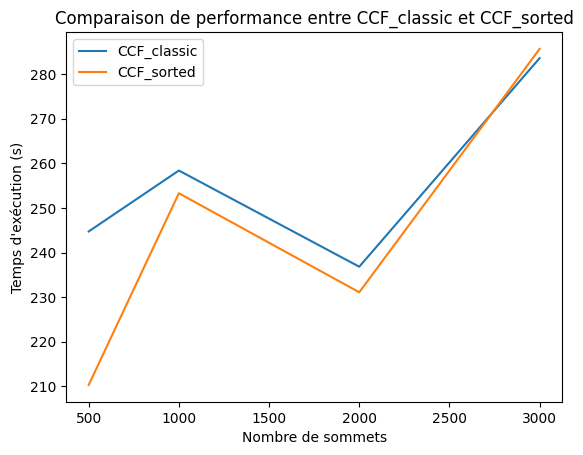

In [6]:
import numpy as np
import random
import timeit
def generate_sample_data(n, m):
    sample_data = [(random.randint(1, n), random.randint(1, n)) for _ in range(m)]
    return sc.parallelize(sample_data)

def compare_algorithms(n, m):
    data = generate_sample_data(n, m)

    start_time = timeit.default_timer()
    result_1 = CCF_classic(data)
    algo_1_time = timeit.default_timer() - start_time

    start_time = timeit.default_timer()
    result_2 = CCF_sorted(data)
    algo_2_time = timeit.default_timer() - start_time

    return algo_1_time, algo_2_time

def plot_comparison(n_range, m_range):
    temps_algo_1 = []
    temps_algo_2 = []

    for n, m in zip(n_range, m_range):
        algo_1_time, algo_2_time = compare_algorithms(n, m)
        temps_algo_1.append(algo_1_time)
        temps_algo_2.append(algo_2_time)

    plt.plot(n_range, temps_algo_1, label="CCF_classic")
    plt.plot(n_range, temps_algo_2, label="CCF_sorted")
    plt.xlabel("Nombre de sommets")
    plt.ylabel("Temps d'exécution (s)")
    plt.legend()
    plt.title("Comparaison de performance entre CCF_classic et CCF_sorted")
    plt.show()

n_range = [500, 1000, 2000, 3000]
m_range = [1000, 2000, 4000, 6000]

plot_comparison(n_range, m_range)


### Deuxieme essai

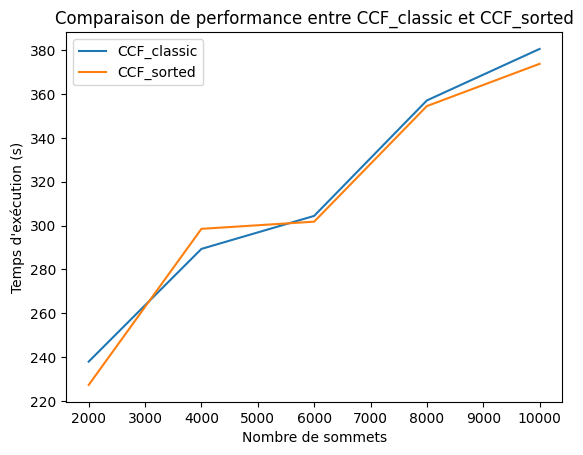

In [7]:
n_range = [2000, 4000, 6000, 8000, 10000]
m_range = [4000, 6000, 8000, 10000, 12000]

plot_comparison(n_range, m_range)


# **Commentaires des résultats** : 
L'algorithme CCF_Sorted fonctionne légèrement mieux que celui non trié (*CCF_Classic*) pour des ensembles de données **plus importants** (de 6000 à 10000 sommets). 

Ce comportement peut être attribué au fait que l'algorithme trié est plus efficace pour filtrer les sommets et séparer l'étiquette minimale des autres voisins en raison de la liste de voisins triée

**Points forts de notre implémentation :**

* Elle fournit une comparaison simple entre les deux algorithmes CCF
* Elle permet de tester les performances des algorithmes sur différentes tailles de jeux de données en faisant varier le nombre de sommets et d'arêtes
* Elle visualise la comparaison des performances à travers un graphique, facilitant ainsi l'analyse des résultats

**Points Faibles de l'implémentation :**

* La génération des jeux de données est aléatoire, ce qui pourrait ne pas refléter les structures de graphe du monde réel
* La mesure de performance repose uniquement sur le temps d'exécution, sans prendre en compte d'autres facteurs tels que l'utilisation de la mémoire

**Amélioration possible :**

* Utiliser des jeux de données réels ou générer des jeux de données synthétiques qui imitent mieux les structures de graphe du monde réel
* Mesurer la consommation de mémoire et d'autres indicateurs de performance pertinents
* Effectuer des tests plus approfondis en faisant varier les paramètres des jeux de données tels que la densité du graphe, le nombre de composantes connexes et la distribution des tailles des composantes
* Optimiser davantage les algorithmes en utilisant les fonctionnalités avancées de Spark, telles que les variables de diffusion, les accumulateurs ou les stratégies de partitionnement